In [ ]:
# %%bash
# # Download the TensorFlow Serving Docker image and repo
# docker pull tensorflow/serving

# git clone https://github.com/tensorflow/serving
# # Location of demo models
# TESTDATA="$(pwd)/serving/tensorflow_serving/servables/tensorflow/testdata"

# # Start TensorFlow Serving container and open the REST API port
# docker run -t --rm -p 8501:8501 \
#     -v "$TESTDATA/saved_model_half_plus_two_cpu:/models/half_plus_two" \
#     -e MODEL_NAME=half_plus_two \
#     tensorflow/serving &

# curl -d '{"instances": [1.0, 2.0, 5.0]}' \
#     -X POST http://localhost:8501/v1/models/half_plus_two:predict


The serving images (both CPU and GPU) have the following properties:
- Port 8500 exposed for gRPC
- Port 8501 exposed for the REST API
- Optional environment variable MODEL_NAME (defaults to model)
- Optional environment variable MODEL_BASE_PATH (defaults to /models)

When the serving image runs ModelServer, it runs it as follows:

`tensorflow_model_server --port=8500 --rest_api_port=8501 \
  --model_name=${MODEL_NAME} --model_base_path=${MODEL_BASE_PATH}/${MODEL_NAME}`

To serve with Docker, you'll need:
- An open port on your host to serve on
- A SavedModel to serve
- A name for your model that your client will refer to

`docker run -p 8501:8501 \
  --mount type=bind,source=/path/to/my_model/,target=/models/my_model \
  -e MODEL_NAME=my_model -t tensorflow/serving
`

In this case, we've started a Docker container, published the REST API port 8501 to our host's port 8501, and taken a model we named `my_model` and bound it to the default model base path (`${MODEL_BASE_PATH}/${MODEL_NAME} = /models/my_model`). Finally, we've filled in the environment variable `MODEL_NAME` with `my_model`, and left `MODEL_BASE_PATH` to its default value.

In [8]:
import os
import tensorflow as tf

MODEL_BASE_PATH = "models"
MODEL_NAME = "20231120-094457/1"
assert tf.saved_model.contains_saved_model(os.path.join(MODEL_BASE_PATH, MODEL_NAME))

In [9]:
model = tf.saved_model.load(os.path.join(MODEL_BASE_PATH, MODEL_NAME))

2023-12-22 16:31:13.525384: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-22 16:31:13.525610: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-22 16:31:13.588663: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [10]:
%%bash
MODEL_NAME="20231120-094457"
MODEL_BASE_PATH="$(pwd)/models/$(MODEL_NAME)"

docker run -p 8501:8501 --mount type=bind,source="$(pwd)/models/20231120-094457",target="/models/flower" -e MODEL_NAME="flower" -t tensorflow/serving

bash: line 2: MODEL_NAME: command not found
docker: Error response from daemon: driver failed programming external connectivity on endpoint keen_easley (8cb556b11f4856fd57c6a112ba46efc87c87de4a0f9672b0b6eccf52f986730a): Bind for 0.0.0.0:8501 failed: port is already allocated.
time="2023-12-22T16:31:21+01:00" level=error msg="error waiting for container: "


CalledProcessError: Command 'b'MODEL_NAME="20231120-094457"\nMODEL_BASE_PATH="$(pwd)/models/$(MODEL_NAME)"\n\ndocker run -p 8501:8501 --mount type=bind,source="$(pwd)/models/20231120-094457",target="/models/20231120-094457" -e MODEL_NAME="20231120-094457" -t tensorflow/serving\n'' returned non-zero exit status 125.

In [1]:
!GET "http://localhost:8504/v1/models/flower"

Der Befehl "GET" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


In [11]:
!curl -X GET "http://localhost:8510/v1/models/flower"

{
 "model_version_status": [
  {
   "version": "1",
   "state": "AVAILABLE",
   "status": {
    "error_code": "OK",
    "error_message": ""
   }
  }
 ]
}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   154  100   154    0     0  16814      0 --:--:-- --:--:-- --:--:-- 17111


# Creating your own serving image
If you want a serving image that has the model built into the container, you can create your own image. This is useful if you want to deploy your model to a cloud provider that doesn't support mounting volumes (e.g. Google Cloud ML Engine). To do this, you'll need:
- A Dockerfile
- A SavedModel to serve
- A name for your model that your client will refer to

The Dockerfile should look something like this:

```
FROM tensorflow/serving
COPY models/my_model /models/my_model
ENV MODEL_NAME my_model
```

Then, you can build and run the Docker image as follows:

```
# Build the image using the credentials saved in .env file
docker build -t <your username>/flower:latest .
docker run -p 8501:8501 -t <your username>/flower
``` 

To push your image to Docker Hub, you can do the following:

```
docker login -u <your username>
docker push <your username>/flower:latest
```


# Using the REST API
The REST API is useful for quick testing and simple use cases. It's not recommended for production use. The REST API is exposed on port 8501. The following endpoints are available:
- `/v1/models/${MODEL_NAME}`: Returns metadata about the model. This is useful for determining the input and output tensors of the model.
- `/v1/models/${MODEL_NAME}:predict`: Performs inference against the model. The request body should be a JSON object with the following fields:
  - `instances`: A list of input tensors to be fed to the model. The shape of each tensor should be defined in the metadata returned from the previous endpoint. The tensors should be serialized using the same format as the tensors in the SavedModel.
  - `signature_name`: The signature of the model to use. If unspecified, the default signature is used.

# Using the gRPC API
The gRPC API is useful for production use cases. It's more efficient than the REST API, and it supports streaming inputs and outputs. The gRPC API is exposed on port 8500. The following endpoints are available:
- `GetModelMetadata`: Returns metadata about the model. This is useful for determining the input and output tensors of the model.
- `Predict`: Performs inference against the model. The request body should be a `PredictRequest` protobuf object with the following fields:
  - `model_spec`: A `ModelSpec` protobuf object with the following fields:
    - `name`: The name of the model to use.
    - `signature_name`: The signature of the model to use. If unspecified, the default signature is used.
  - `inputs`: A map of input tensors to be fed to the model. The shape of each tensor should be defined in the metadata returned from the previous endpoint. The tensors should be serialized using the same format as the tensors in the SavedModel.

In [ ]:
%%bash
# run your service as a demon
docker run -d --name serving_base tensorflow/serving

# copy your model into the container
docker cp models/20231120-094457 serving_base:/models/20231120-094457

# commit the changes
docker commit --change "ENV MODEL_NAME 20231120-094457" serving_base 20231120-094457

# stop the container
docker kill serving_base

## Inference of served TensorFlow model
In the next sections, the docker contaienr containing the trained model is infered using the test data from our database.

In [12]:
import requests
import time
import json
import os
from dotenv import load_dotenv
from pymongo import MongoClient
from MongoDBDataset import create_dataset, get_vocab
import matplotlib.pyplot as plt
import numpy as np

load_dotenv()
%matplotlib inline

In [21]:
def classify_flower(data: np.ndarray, host, port, model_name):
    # track time
    start_time_inference = time.time()

    url = f"http://{host}:{port}/v1/models/{model_name}:predict"
    print(f"Performing model inference with url: {url}")
    try:
        response = requests.post(url=url, json={"instances": data.tolist()})
        print(response.text)
        print(f"Status code: {response.status_code}")
        # predictions = json.loads(json_response.text)["predictions"]

    except Exception as e:
        raise RuntimeError(f"Could not get a response from url {url} because of Exception: {e}.")

    # log inference time
    print(f"Performing model inference took {time.time() - start_time_inference} seconds.")

    return response.json()


def extract_highest_scoring_category(label):
    return np.argmax(label)

In [18]:
client = MongoClient(os.environ["URI"])
db = client.flowers
category_flower_mapping = {value: key for key, value in get_vocab(db.test).items()}
eval_dataset = create_dataset(db.test, batch_size=3, mode="test")

Performing model inference with url: http://localhost:8510/v1/models/flower:predict
{
    "predictions": [[0.000403174461, 1.16367992e-05, 0.000227044788, 0.000543266826, 1.11961401e-06, 0.997164428, 5.20911726e-07, 0.00125323702, 0.000236515611, 5.077682e-05, 2.10448778e-08, 3.4845149e-09, 1.4821178e-06, 0.000106772801], [0.00155953597, 1.50146398e-05, 7.00728851e-05, 0.485246509, 0.0612382628, 6.21206937e-07, 0.408607602, 0.0375905521, 4.02054809e-07, 0.00254716701, 3.65506793e-07, 4.0225234e-07, 0.00282153348, 0.000301879249], [2.84422498e-07, 1.44869583e-08, 1.0064703e-05, 7.34641787e-07, 6.83905377e-10, 0.999978423, 2.57324197e-12, 2.88754291e-06, 6.32926776e-06, 4.82113123e-08, 9.13054379e-08, 2.15148559e-11, 6.16955287e-09, 1.19308743e-06]
    ]
}
Status code: 200
Performing model inference took 2.5816586017608643 seconds.
{'predictions': [[0.000403174461, 1.16367992e-05, 0.000227044788, 0.000543266826, 1.11961401e-06, 0.997164428, 5.20911726e-07, 0.00125323702, 0.000236515611, 

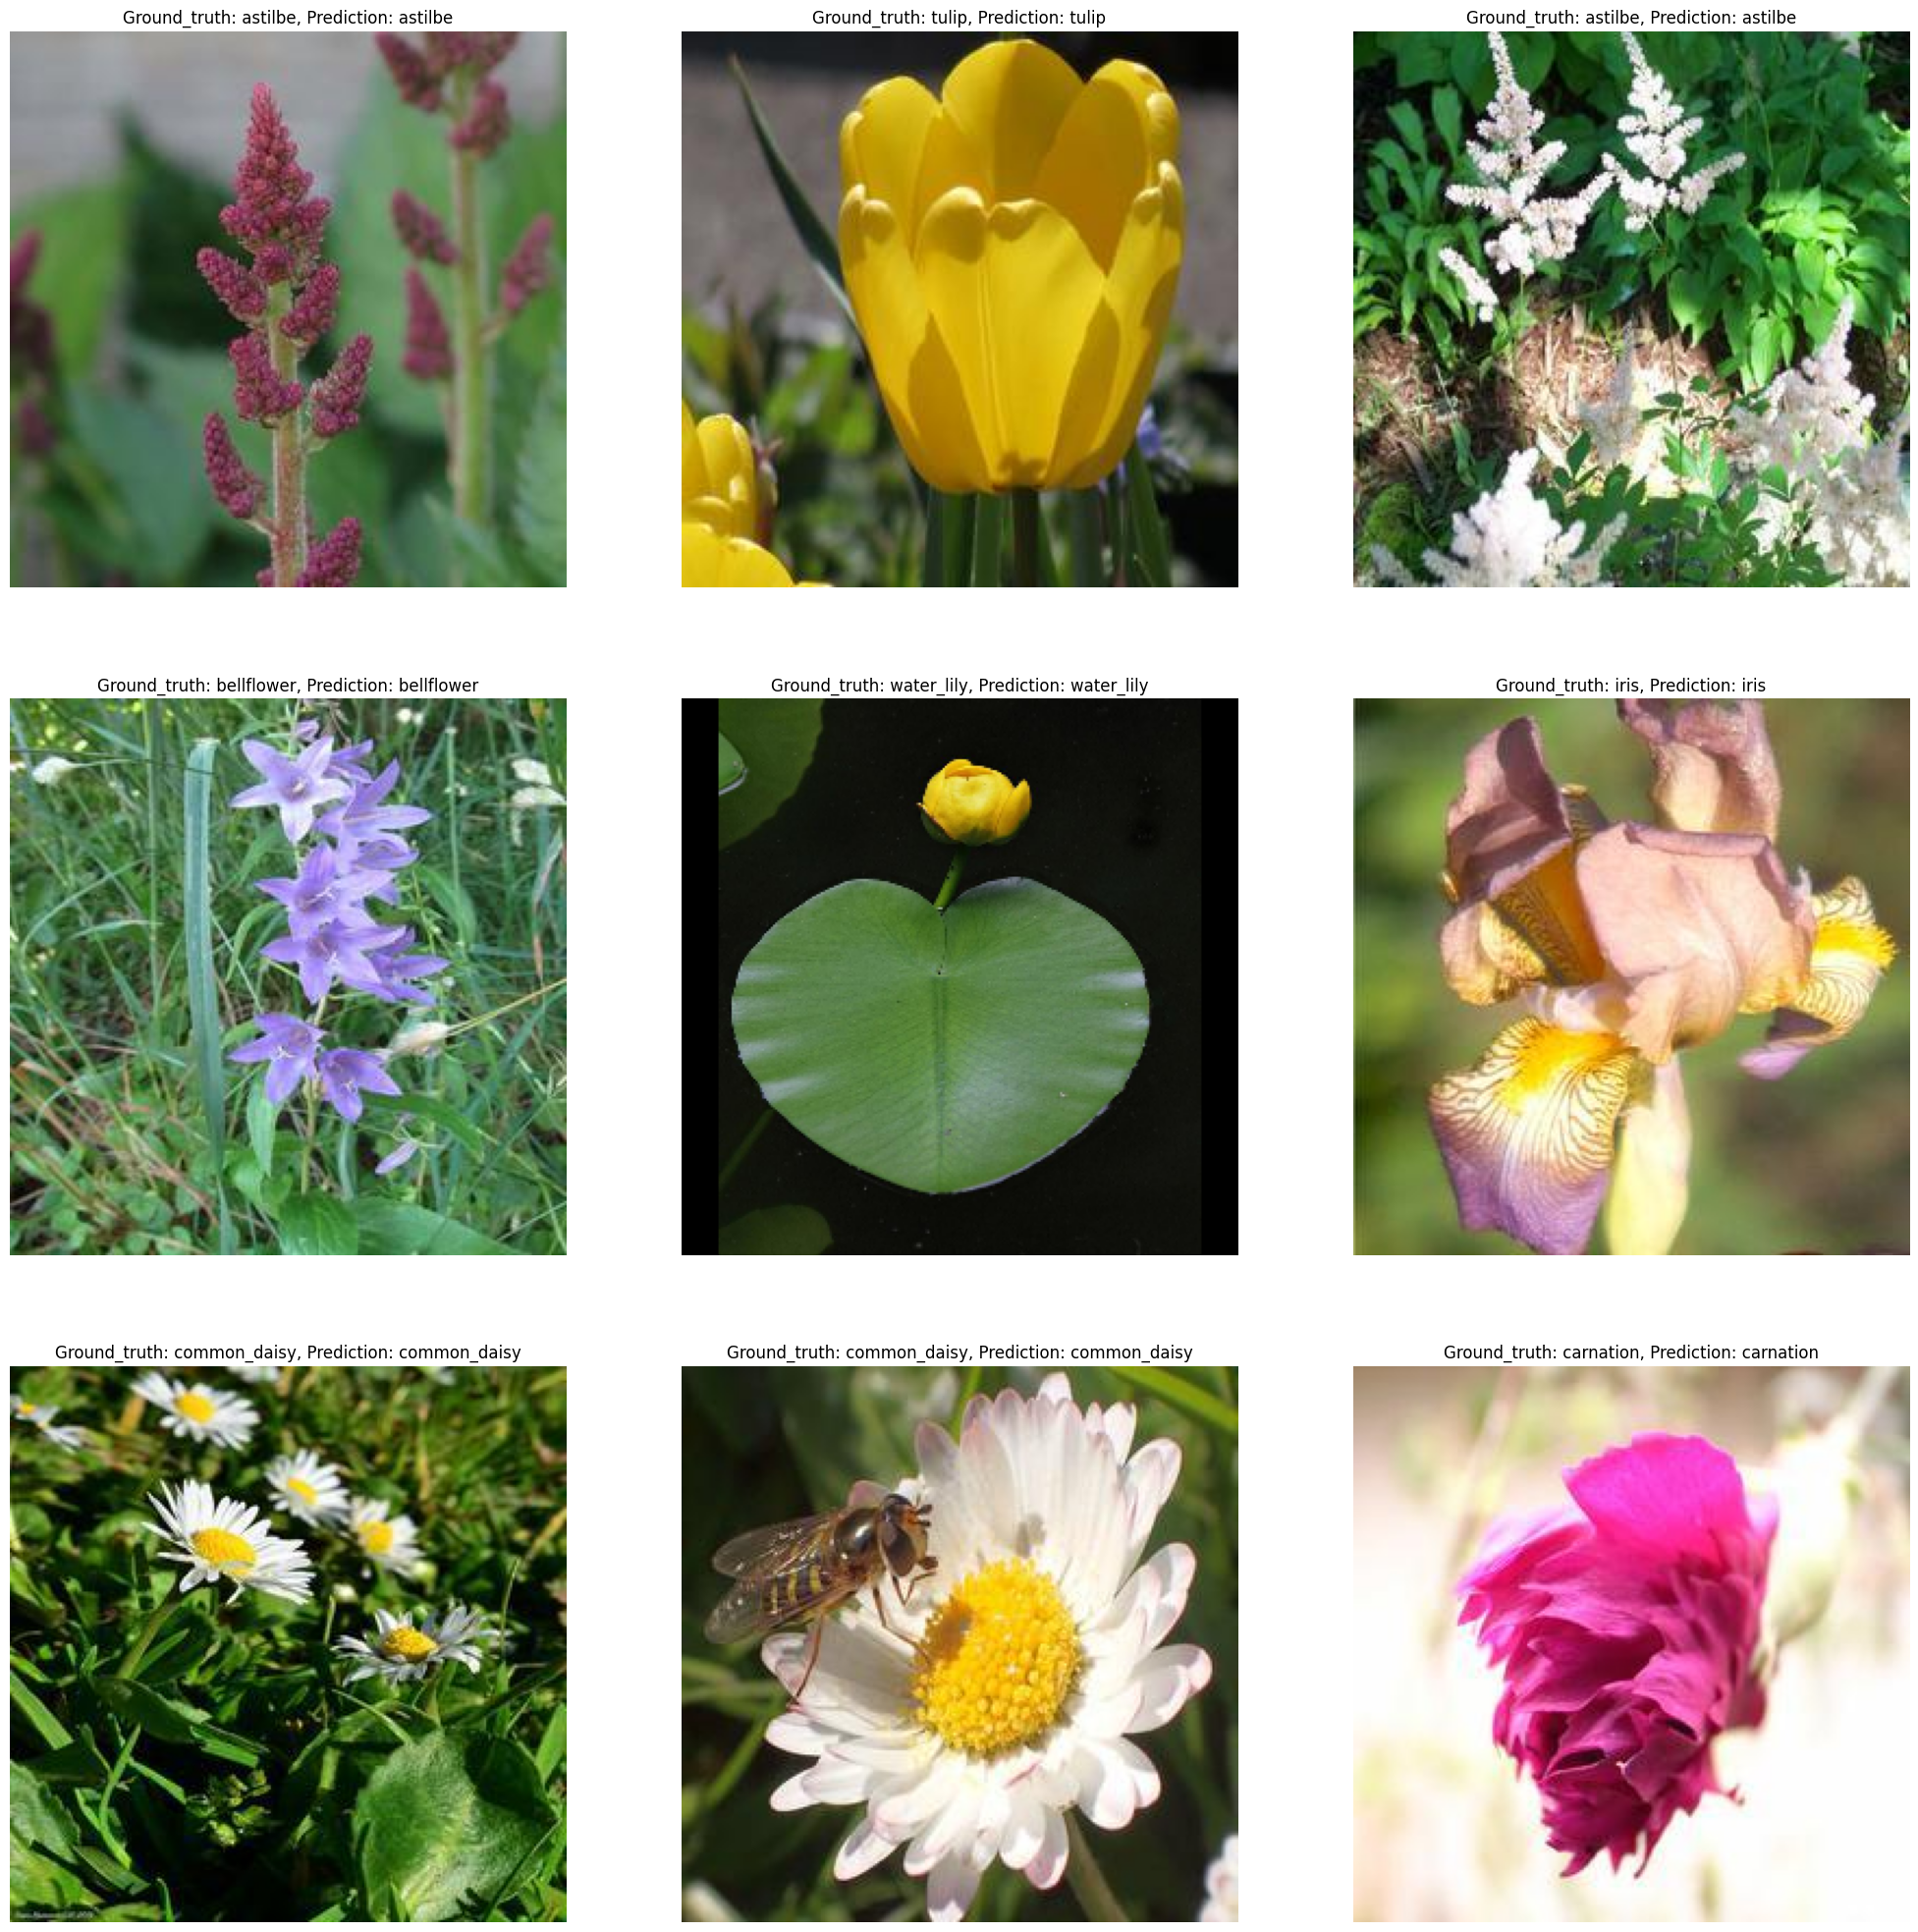

In [24]:
n_col = 3
n_plots = 3 * 3 // n_col
fig = plt.figure(figsize=(25, 25))


for n_image, (data, label) in enumerate(eval_dataset.take(3).as_numpy_iterator(), start=1):
    response = classify_flower(data, "localhost", 8510, "flower")
    for i in range(3):
        ax = fig.add_subplot(n_plots, n_col, (n_image - 1) * 3 + i + 1)
        print(response)
        ax.set_title(
            f"Ground_truth: {category_flower_mapping[extract_highest_scoring_category(label[i])]}"
            f", Prediction: {category_flower_mapping[extract_highest_scoring_category(label[i])]}"
        )
        ax.imshow(data[i].astype(int).squeeze())
        ax.axis("off")